# Libraries needed

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Dataset & Preprocessing

In [48]:
# Load the dataset
data = pd.read_csv('placementdata.csv')

# Display the first few rows of the dataset
data.head()


,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [49]:
# Count the number of students placed and not placed
placement_counts = data['PlacementStatus'].value_counts()
print("Placement Status Counts:")
print(placement_counts)

Placement Status Counts:
PlacementStatus
NotPlaced    5803
Placed       4197
Name: count, dtype: int64


In [50]:
# Data Preprocessing
# Handle missing values
data.fillna(method='ffill', inplace=True)

# Drop the StudentID column
data.drop(columns=['StudentID'], inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_columns = ['ExtracurricularActivities', 'PlacementTraining', 'PlacementStatus']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

print("Encoded Data:")
print(data.head())

Encoded Data:
   CGPA  Internships  Projects  Workshops/Certifications  AptitudeTestScore  \
0   7.5            1         1                         1                 65   
1   8.9            0         3                         2                 90   
2   7.3            1         2                         2                 82   
3   7.5            1         1                         2                 85   
4   8.3            1         2                         2                 86   

   SoftSkillsRating  ExtracurricularActivities  PlacementTraining  SSC_Marks  \
0               4.4                          0                  0         61   
1               4.0                          1                  1         78   
2               4.8                          1                  0         79   
3               4.4                          1                  1         81   
4               4.5                          1                  1         74   

   HSC_Marks  PlacementStatus 

C:\Users\asus\AppData\Local\Temp\ipykernel_34392\3968905314.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [41]:
# Scale numerical features only
numerical_columns = ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'SSC_Marks', 'HSC_Marks']
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Display results
print("Encoded and Scaled Data:")
print(data.head())

Encoded and Scaled Data:
       CGPA  Internships  Projects  Workshops/Certifications  \
0 -0.309343    -0.073889 -1.182822                 -0.014598   
1  1.877818    -1.575689  1.121526                  1.091319   
2 -0.621794    -0.073889 -0.030648                  1.091319   
3 -0.309343    -0.073889 -1.182822                  1.091319   
4  0.940464    -0.073889 -0.030648                  1.091319   

   AptitudeTestScore  SoftSkillsRating  ExtracurricularActivities  \
0          -1.770910          0.184742                          0   
1           1.292970         -0.787072                          1   
2           0.312528          1.156555                          1   
3           0.680194          0.184742                          1   
4           0.802749          0.427695                          1   

   PlacementTraining  SSC_Marks  HSC_Marks  PlacementStatus  
0                  0  -0.782306   0.504368                0  
1                  1   0.847618   0.840726         

In [51]:
# Define features and target
target = 'PlacementStatus' 
features = [col for col in data.columns if col != 'PlacementStatus']

In [52]:
# Apply K-Means Clustering with 2 clusters
model = KMeans(n_clusters=2, init='k-means++', random_state=42)
model.fit(data[features])

# Get cluster labels
labels = model.labels_

# Add cluster labels to the dataset
data['Cluster'] = labels

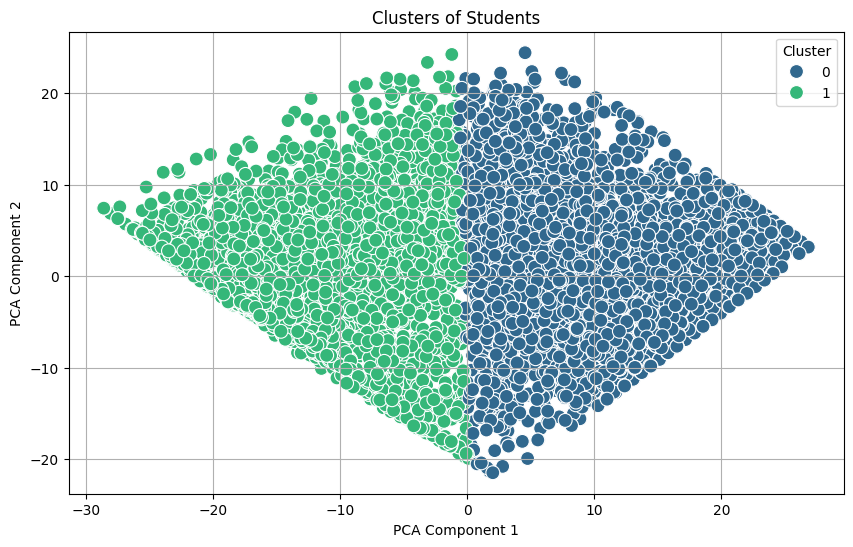

In [53]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis', s=100)
plt.title('Clusters of Students')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [54]:
# Calculate metrics
accuracy = accuracy_score(data[target], labels)
precision = precision_score(data[target], labels, average='weighted')
recall = recall_score(data[target], labels, average='weighted')
f1 = f1_score(data[target], labels, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.2443
Precision: 0.2560936441599871
Recall: 0.2443
F1 Score: 0.24910142542126062


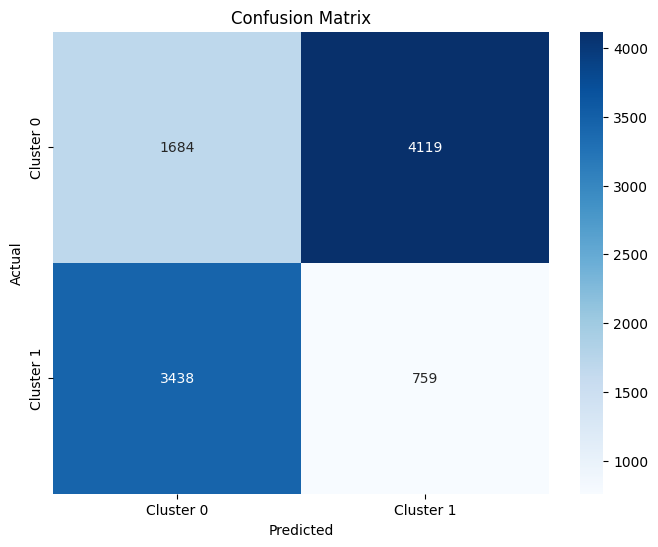

In [55]:
# Create confusion matrix
conf_matrix = confusion_matrix(data[target], labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Cluster 0', 'Cluster 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()